In [2]:
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
import bigfish.detection as detection
import bigfish.plot as plot
import bigfish.stack as stack
from tqdm import tqdm
import FISH_quant
from FISH_quant import *
from importlib import reload
import os
from cellpose import models
from cellpose.io import imread
from cellpose import plot
import matplotlib as mpl
from cellpose import utils, io
import seaborn as sns
import pickle
from cellpose import plot as cell_plot
import scipy.stats as stats
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib
mpl.rcParams['figure.dpi'] = 300

In [3]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

In [15]:
def run_quant(image_filename):
    #load images
    kcnk9_image = ski.io.imread(image_filename + "Kcnk9.tif")
    smi32_image = ski.io.imread(image_filename + "Smi32.tif")
    rbpms_image = ski.io.imread(image_filename + "Rbpms.tif")
    dapi_image  = ski.io.imread(image_filename + "DAPI.tif")

    #identify Kcnk9 puncta
    kcnk9_spots, kcnk9_threshold = detect_spots(kcnk9_image, 150, pixel_size=390.625, filter_kernel=2, threshold_mod=1.2)
    
    #identify Kcnk9 puncta overlapping with Rbpms and Smi32
    kcnk9_spots_rbpms = spots_in_mask(rbpms_image, kcnk9_spots, 2)
    kcnk9_spots_smi32 = spots_in_mask(smi32_image, kcnk9_spots, 2)

    #save images showing Kcnk9 puncta
    label_spots(kcnk9_image, kcnk9_spots, saveas=image_filename + "kcnk9_spots_labeled.png", show=False)
    label_spots(kcnk9_image, kcnk9_spots_rbpms, saveas=image_filename + "rbpms_kcnk9_spots_labeled.png", show=False)
    label_spots(kcnk9_image, kcnk9_spots_smi32, saveas=image_filename + "smi32_kcnk9_spots_labeled.png", show=False)
    
    #find the mean intensity of Kcnk9 puncta in Rbpms and Smi32
    rbpms_kcnk9_intensity = mean_spot_intensity(kcnk9_image, kcnk9_spots_rbpms)
    smi32_kcnk9_intensity = mean_spot_intensity(kcnk9_image, kcnk9_spots_smi32)
    
    #find RGCs
    rbpms_dapi_rgb = np.dstack((rbpms_image, dapi_image, np.zeros(rbpms_image.shape))).astype(int)
    rbpms_masks, rbpms_flows, rbpms_styles = segment_cells(rbpms_dapi_rgb, 1, 2)
    kcnk9_count_dist = count_spots_per_cell(rbpms_masks, kcnk9_spots)
    kcnk9_int_dist = calculate_intensity_per_cell(rbpms_masks, kcnk9_image)
    
    show_segmentation(rbpms_image, rbpms_masks, rbpms_flows, 1, 2, saveas=image_filename + "rbpms_segmentation.png")
    show_segmentation(dapi_image, rbpms_masks, rbpms_flows, 1, 2, saveas=image_filename + "dapi_segmentation.png")

    show_spots_in_cells(rbpms_masks, kcnk9_spots, kcnk9_image, show=False, saveas=image_filename + "spots_in_cells.png")
    
    return kcnk9_count_dist, kcnk9_int_dist, rbpms_masks

In [5]:
file_prefix = "path/to/images/"

In [6]:
conditions = ["Ctrl/", "B2Ko/"]

In [7]:
reps = ["Rep1/", "Rep2/", "Rep3/"]

In [8]:
samples = ["1_", "2_", "3_"]

In [ ]:
count_dists = []
int_dists = []
image_masks = []
for i in conditions:
    cd_conds = []
    id_conds = []
    mk_conds = []
    for j in reps:
        cd_reps = []
        id_reps = []
        mk_reps = []
        for k in samples:
            filename = file_prefix + i + j + k
            print(filename)
            cd, id, mk = run_quant(filename)
            cd_reps.append(cd)
            id_reps.append(id)
            mk_reps.append(mk)
        cd_conds.append(cd_reps)
        id_conds.append(id_reps)
        mk_conds.append(mk_reps)
    count_dists.append(cd_conds)
    int_dists.append(id_conds)
    image_masks.append(mk_conds)

In [21]:
pickle.dump(count_dists, open('kcnk9_count_dist.pkl', 'wb'))
pickle.dump(int_dists, open('kcnk9_int_dist.pkl', 'wb'))
pickle.dump(image_masks, open('rbpms_masks.pkl', 'wb'))

In [4]:
count_dists = pickle.load(open('kcnk9_count_dist.pkl', 'rb'))
int_dists = pickle.load(open('kcnk9_int_dist.pkl', 'rb'))
image_masks = pickle.load(open('rbpms_masks.pkl', 'rb'))

In [ ]:
for i in range(len(conditions)):
    for j in range(len(reps)):
        for k in range(len(samples)):
            filename = file_prefix + conditions[i] + reps[j] + samples[k]
            save_filename = filename +  "mask.png"
            smi32_image = ski.io.imread(filename + "Smi32.tif")
            print(filename)
            mask = image_masks[i][j][k]
            plt.imshow(smi32_image)
            for l in range(1,np.max(mask)):
                ii = np.nonzero(mask == l)
                x = np.mean(ii[1])
                y = np.mean(ii[0])
                plt.annotate(l, (x,y), fontsize=6, ha='center', va='center')
            plt.savefig(save_filename)
            plt.close()

In [10]:
smi32_positive_cells = [[[[3], [12], [29, 27, 19, 26, 4]],
                         [[17, 5, 39], [13, 25, 7, 8], [35, 9]],
                         [[5, 7], [10], [15, 7, 27]]],
                        [[[18, 6, 9, 32], [25, 16, 5], [7]],
                         [[30, 3, 2, 1, 23], [9], [33, 23, 13, 30]],
                         [[32, 3], [9, 12], [7, 39, 91, 98, 19]]]]

In [11]:
smi32_positive_count_dists = []
smi32_positive_int_dists = []
for i in range(len(conditions)):
    cd_cond = []
    id_cond = []
    for j in range(len(reps)):
        cd_rep = []
        id_rep = []
        for k in range(len(samples)):
            cd = []
            id = []
            smi32_indices = smi32_positive_cells[i][j][k]
            for l in smi32_indices:
                cd.append(count_dists[i][j][k][l-1])
                id.append(int_dists[i][j][k][l-1])
            cd_rep.append(cd)
            id_rep.append(id)
        cd_cond.append(cd_rep)
        id_cond.append(id_rep)
    smi32_positive_count_dists.append(cd_cond)
    smi32_positive_int_dists.append(id_cond)

In [12]:
pickle.dump(smi32_positive_count_dists, open('smi32_positive_kcnk9_count_dist.pkl', 'wb'))
pickle.dump(smi32_positive_int_dists, open('smi32_positive_kcnk9_int_dist.pkl', 'wb'))

In [13]:
count_dist_plot = []
for i in count_dists:
    for j in i:
        rep_count_dist = []
        for k in j:
            for l in k:
                rep_count_dist.append(l)
        count_dist_plot.append(rep_count_dist)

In [14]:
int_dist_plot = []
for i in int_dists:
    for j in i:
        rep_int_dist = []
        for k in j:
            for l in k:
                rep_int_dist.append(l)
        int_dist_plot.append(rep_int_dist)

In [15]:
smi32_positive_count_dist_plot = []
for i in smi32_positive_count_dists:
    for j in i:
        rep_count_dist = []
        for k in j:
            for l in k:
                rep_count_dist.append(l)
        smi32_positive_count_dist_plot.append(rep_count_dist)

In [16]:
smi32_positive_int_dist_plot = []
for i in smi32_positive_int_dists:
    for j in i:
        rep_int_dist = []
        for k in j:
            for l in k:
                rep_int_dist.append(l)
        smi32_positive_int_dist_plot.append(rep_int_dist)

In [17]:
count_dist_plot_agg = []
count_dist_plot_agg.append([j for i in count_dist_plot[:3] for j in i])
count_dist_plot_agg.append([j for i in count_dist_plot[3:] for j in i])

In [18]:
int_dist_plot_agg = []
int_dist_plot_agg.append([j for i in int_dist_plot[:3] for j in i])
int_dist_plot_agg.append([j for i in int_dist_plot[3:] for j in i])

In [19]:
smi32_positive_count_dist_plot_agg = []
smi32_positive_count_dist_plot_agg.append([j for i in smi32_positive_count_dist_plot[:3] for j in i])
smi32_positive_count_dist_plot_agg.append([j for i in smi32_positive_count_dist_plot[3:] for j in i])

In [20]:
smi32_positive_int_dist_plot_agg = []
smi32_positive_int_dist_plot_agg.append([j for i in smi32_positive_int_dist_plot[:3] for j in i])
smi32_positive_int_dist_plot_agg.append([j for i in smi32_positive_int_dist_plot[3:] for j in i])

In [21]:
count_test = stats.mannwhitneyu(count_dist_plot_agg[0], count_dist_plot_agg[1], alternative='two-sided')

In [34]:
palette = ['#2171b5', '#cb181d']

C:\Users\pomat\AppData\Local\Temp\ipykernel_26004\3830260955.py:2: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(count_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)


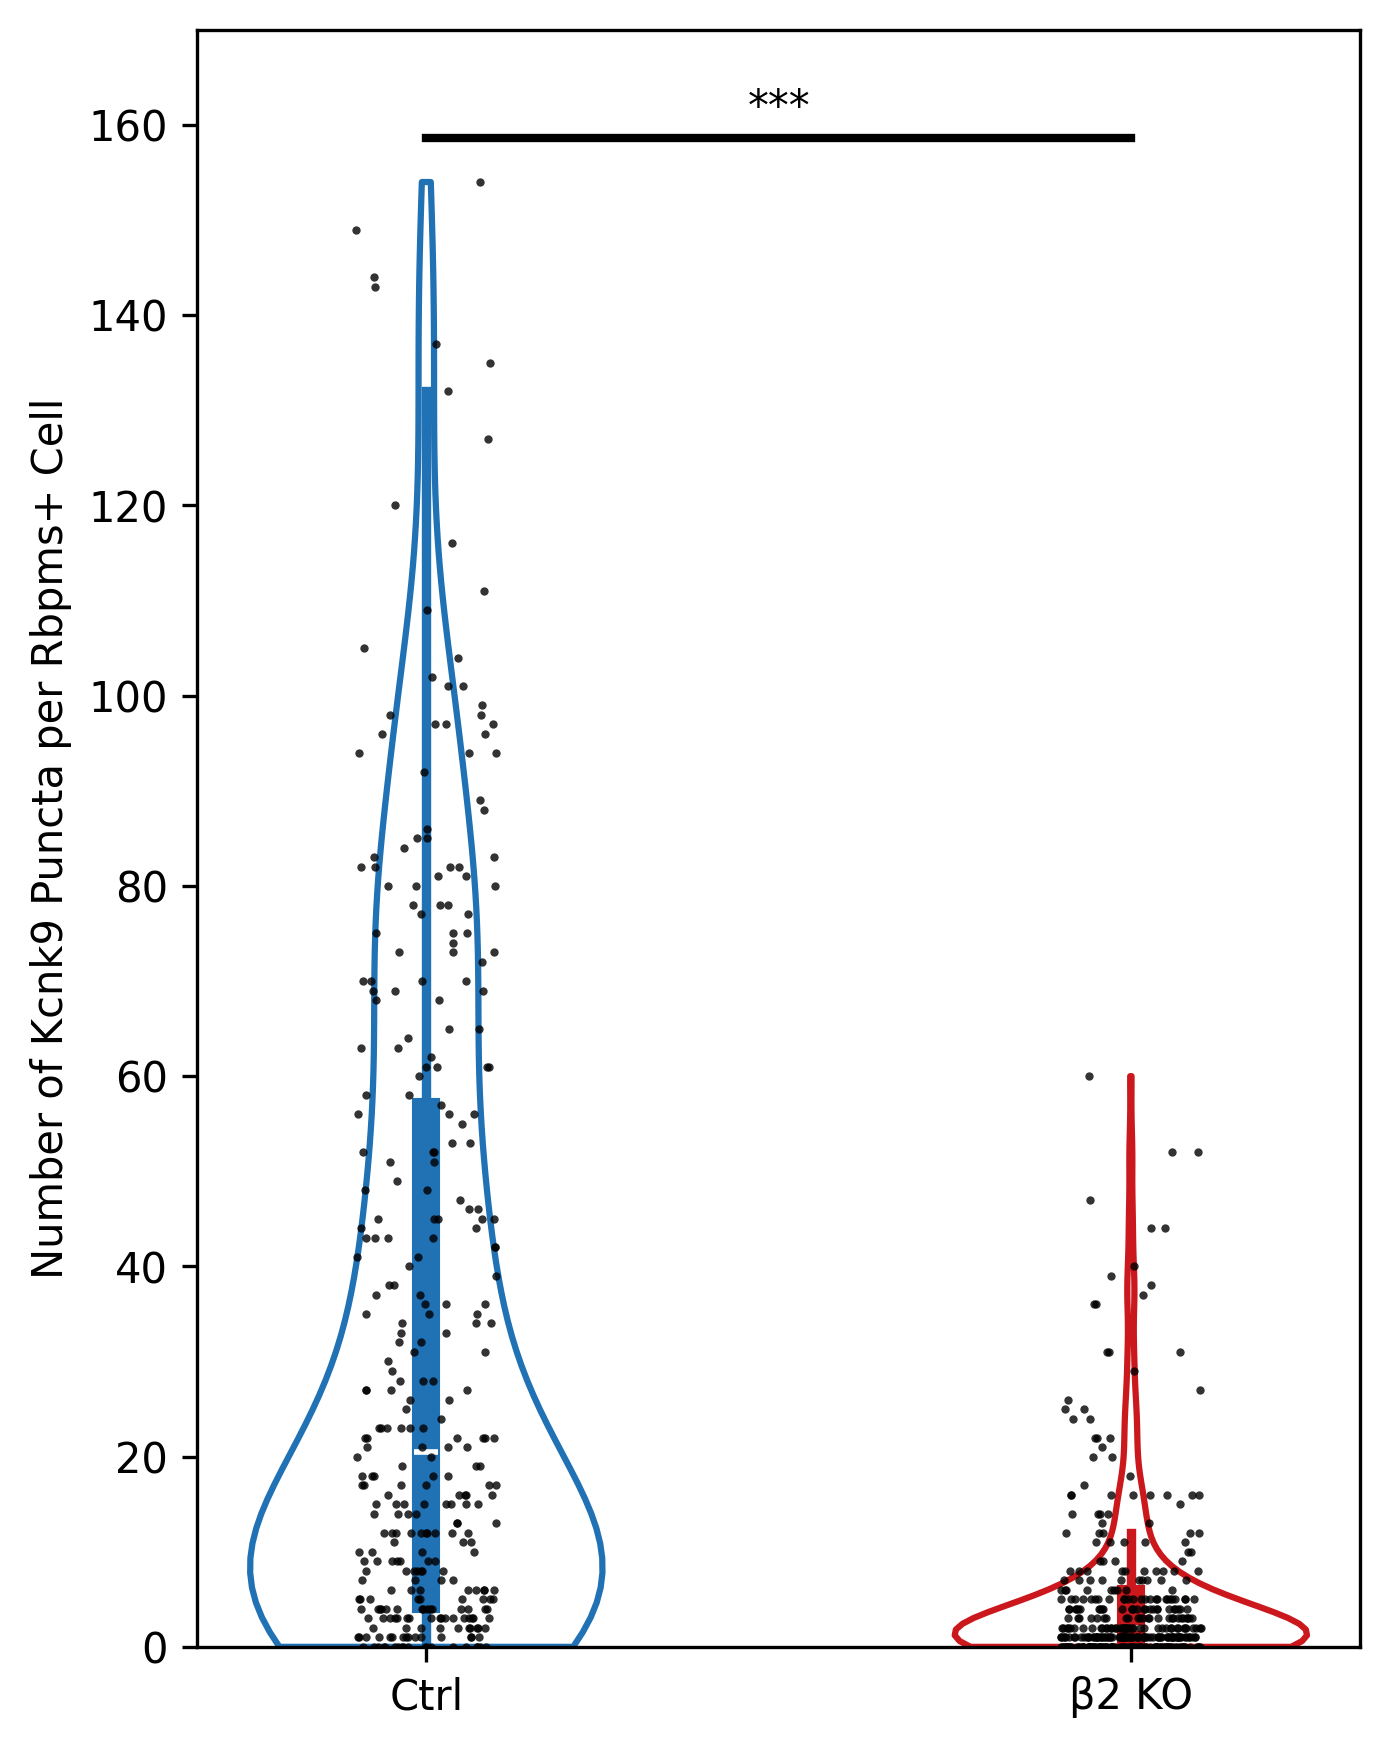

In [39]:
fig, axs = plt.subplots(figsize=(5,7))
sns.violinplot(count_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)
sns.stripplot(count_dist_plot_agg, color='black', alpha=0.8, size=2)
pval_line_height = 1.03*np.max(count_dist_plot_agg[0])
plt.plot([0,1],[pval_line_height, pval_line_height], c='black', lw=2)
plt.xticks([0,1], ["Ctrl", "β2 KO"])
plt.ylabel("Number of Kcnk9 Puncta per Rbpms+ Cell")
plt.text(0.5, 1.02*pval_line_height, f'***', ha='center', va='center')
plt.ylim([0,170])
plt.savefig('FISH_Quant_Count_Rbpms.svg', dpi=500)

C:\Users\pomat\AppData\Local\Temp\ipykernel_26004\3863457895.py:2: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(count_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)


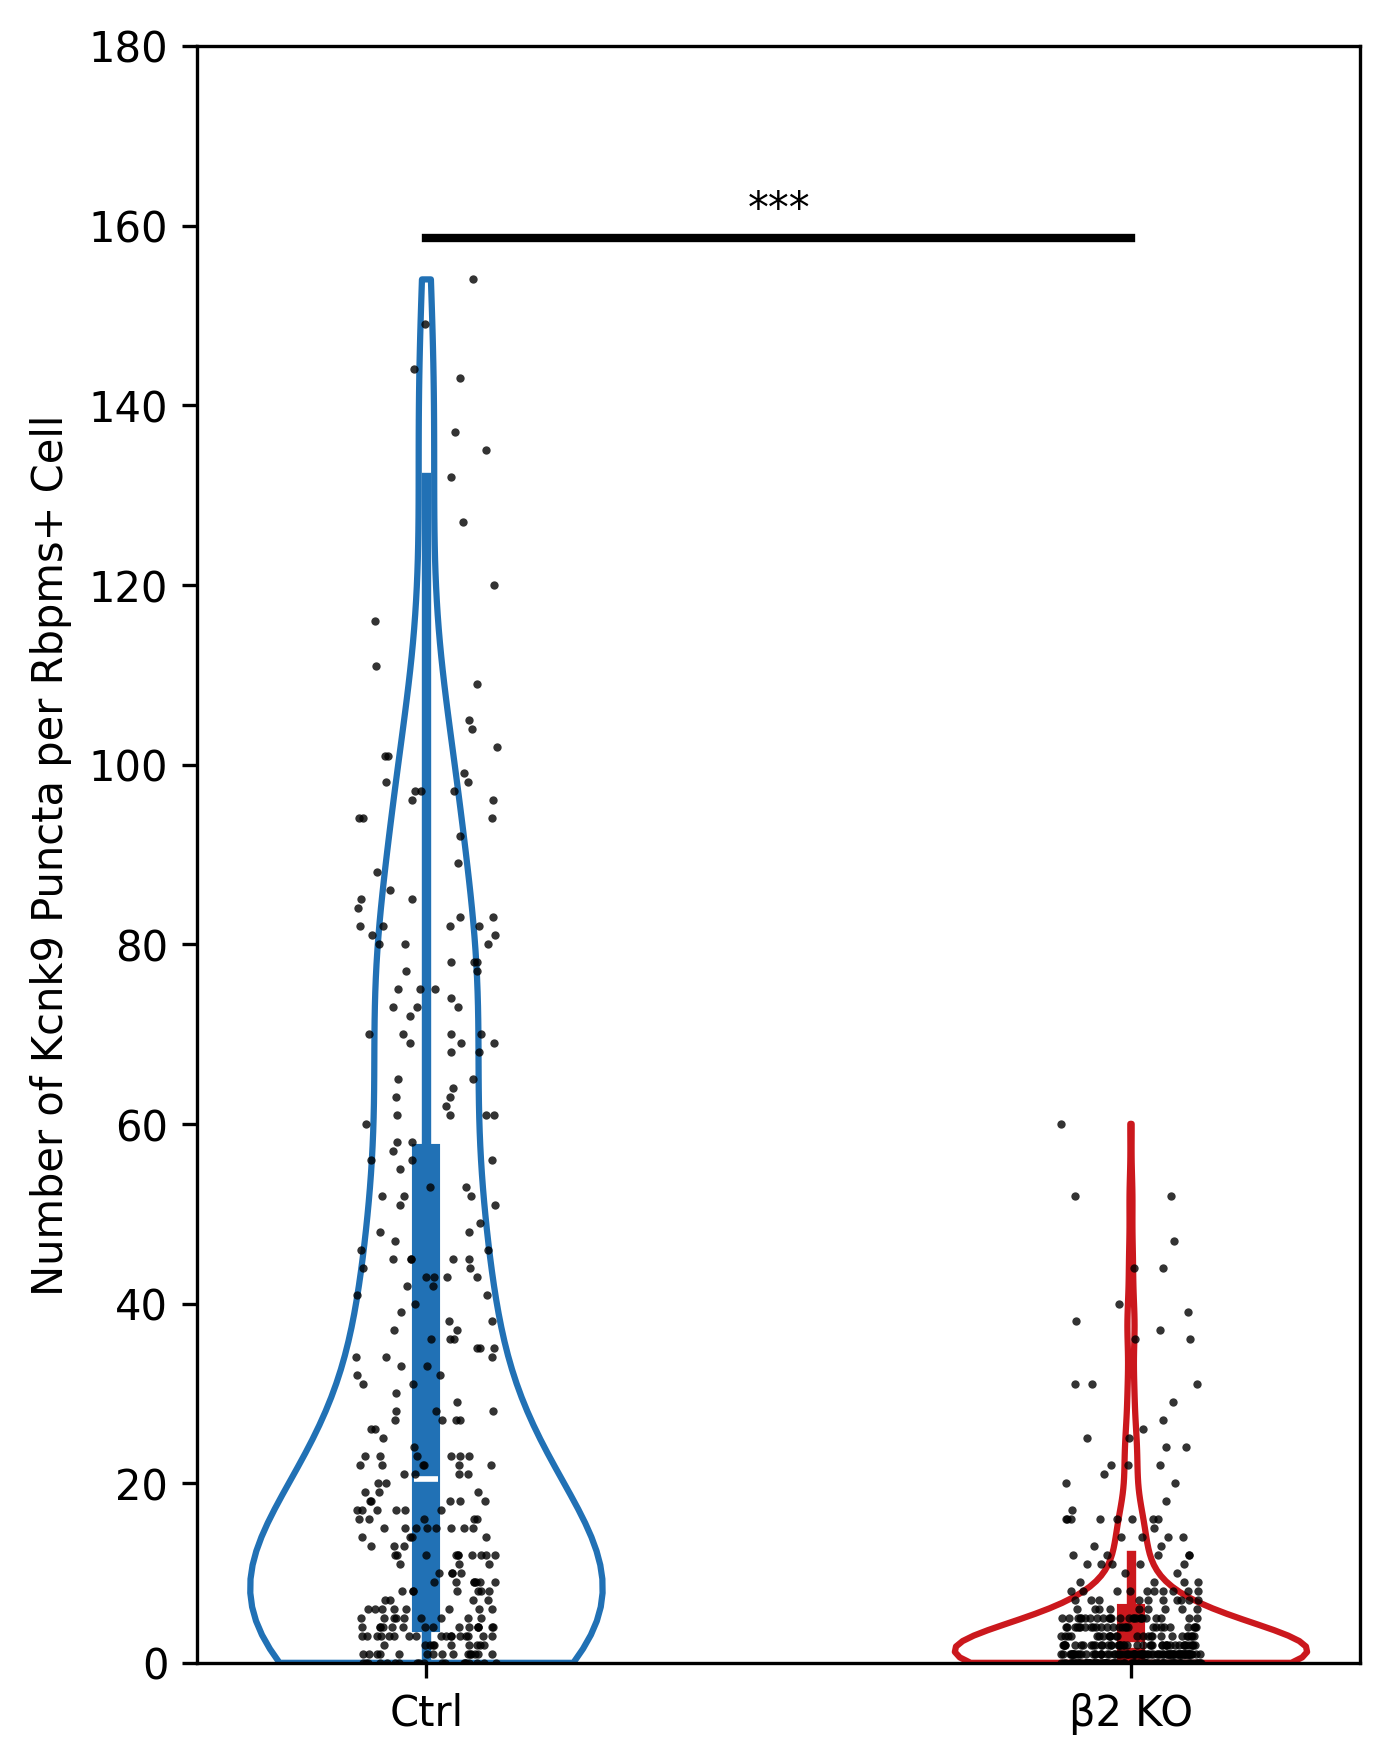

In [43]:
fig, axs = plt.subplots(figsize=(5,7))
sns.violinplot(count_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)
sns.stripplot(count_dist_plot_agg, color='black', alpha=0.8, size=2)
pval_line_height = 1.03*np.max(count_dist_plot_agg[0])
plt.plot([0,1],[pval_line_height, pval_line_height], c='black', lw=2)
plt.xticks([0,1], ["Ctrl", "β2 KO"])
plt.ylabel("Number of Kcnk9 Puncta per Rbpms+ Cell")
plt.text(0.5, 1.02*pval_line_height, f'***', ha='center', va='center')
plt.ylim([0,180])
plt.savefig('FISH_Quant_Count_Rbpms.png', dpi=500)

In [26]:
int_test = stats.mannwhitneyu(int_dist_plot_agg[0], int_dist_plot_agg[1], alternative='two-sided')

C:\Users\pomat\AppData\Local\Temp\ipykernel_26004\1116614396.py:2: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(int_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)


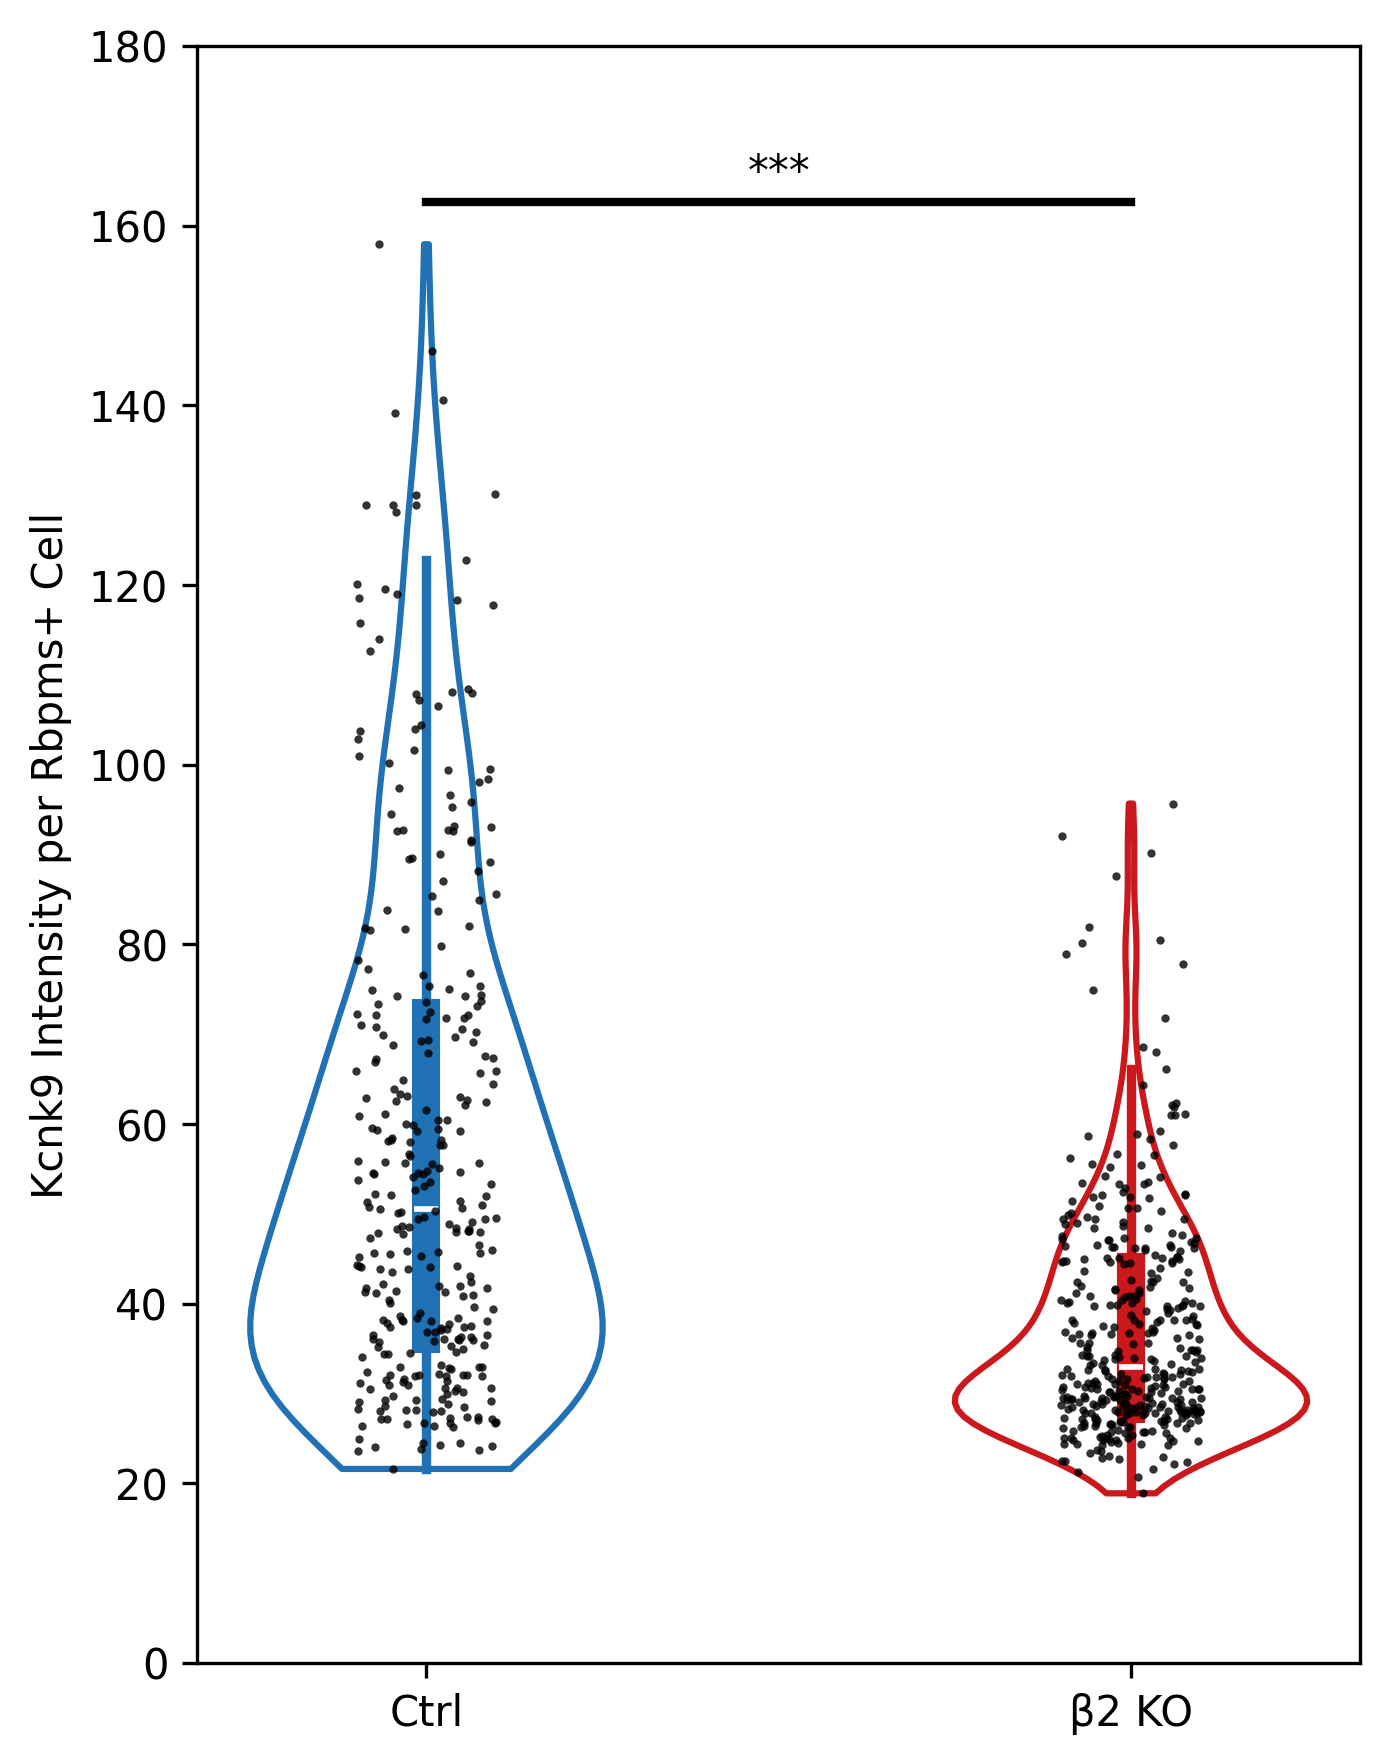

In [44]:
fig, axs = plt.subplots(figsize=(5,7))
sns.violinplot(int_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)
sns.stripplot(int_dist_plot_agg, color='black', alpha=0.8, size=2)
pval_line_height = 1.03*np.max(int_dist_plot_agg[0])
plt.plot([0,1],[pval_line_height, pval_line_height], c='black', lw=2)
plt.xticks([0,1], ["Ctrl", "β2 KO"])
plt.ylabel("Kcnk9 Intensity per Rbpms+ Cell")
plt.text(0.5, 1.02*pval_line_height, f'***', ha='center', va='center')
plt.ylim([0,180])
plt.savefig('FISH_Quant_Int_Rbpms.svg', dpi=500)

C:\Users\pomat\AppData\Local\Temp\ipykernel_26004\3278122285.py:2: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(int_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)


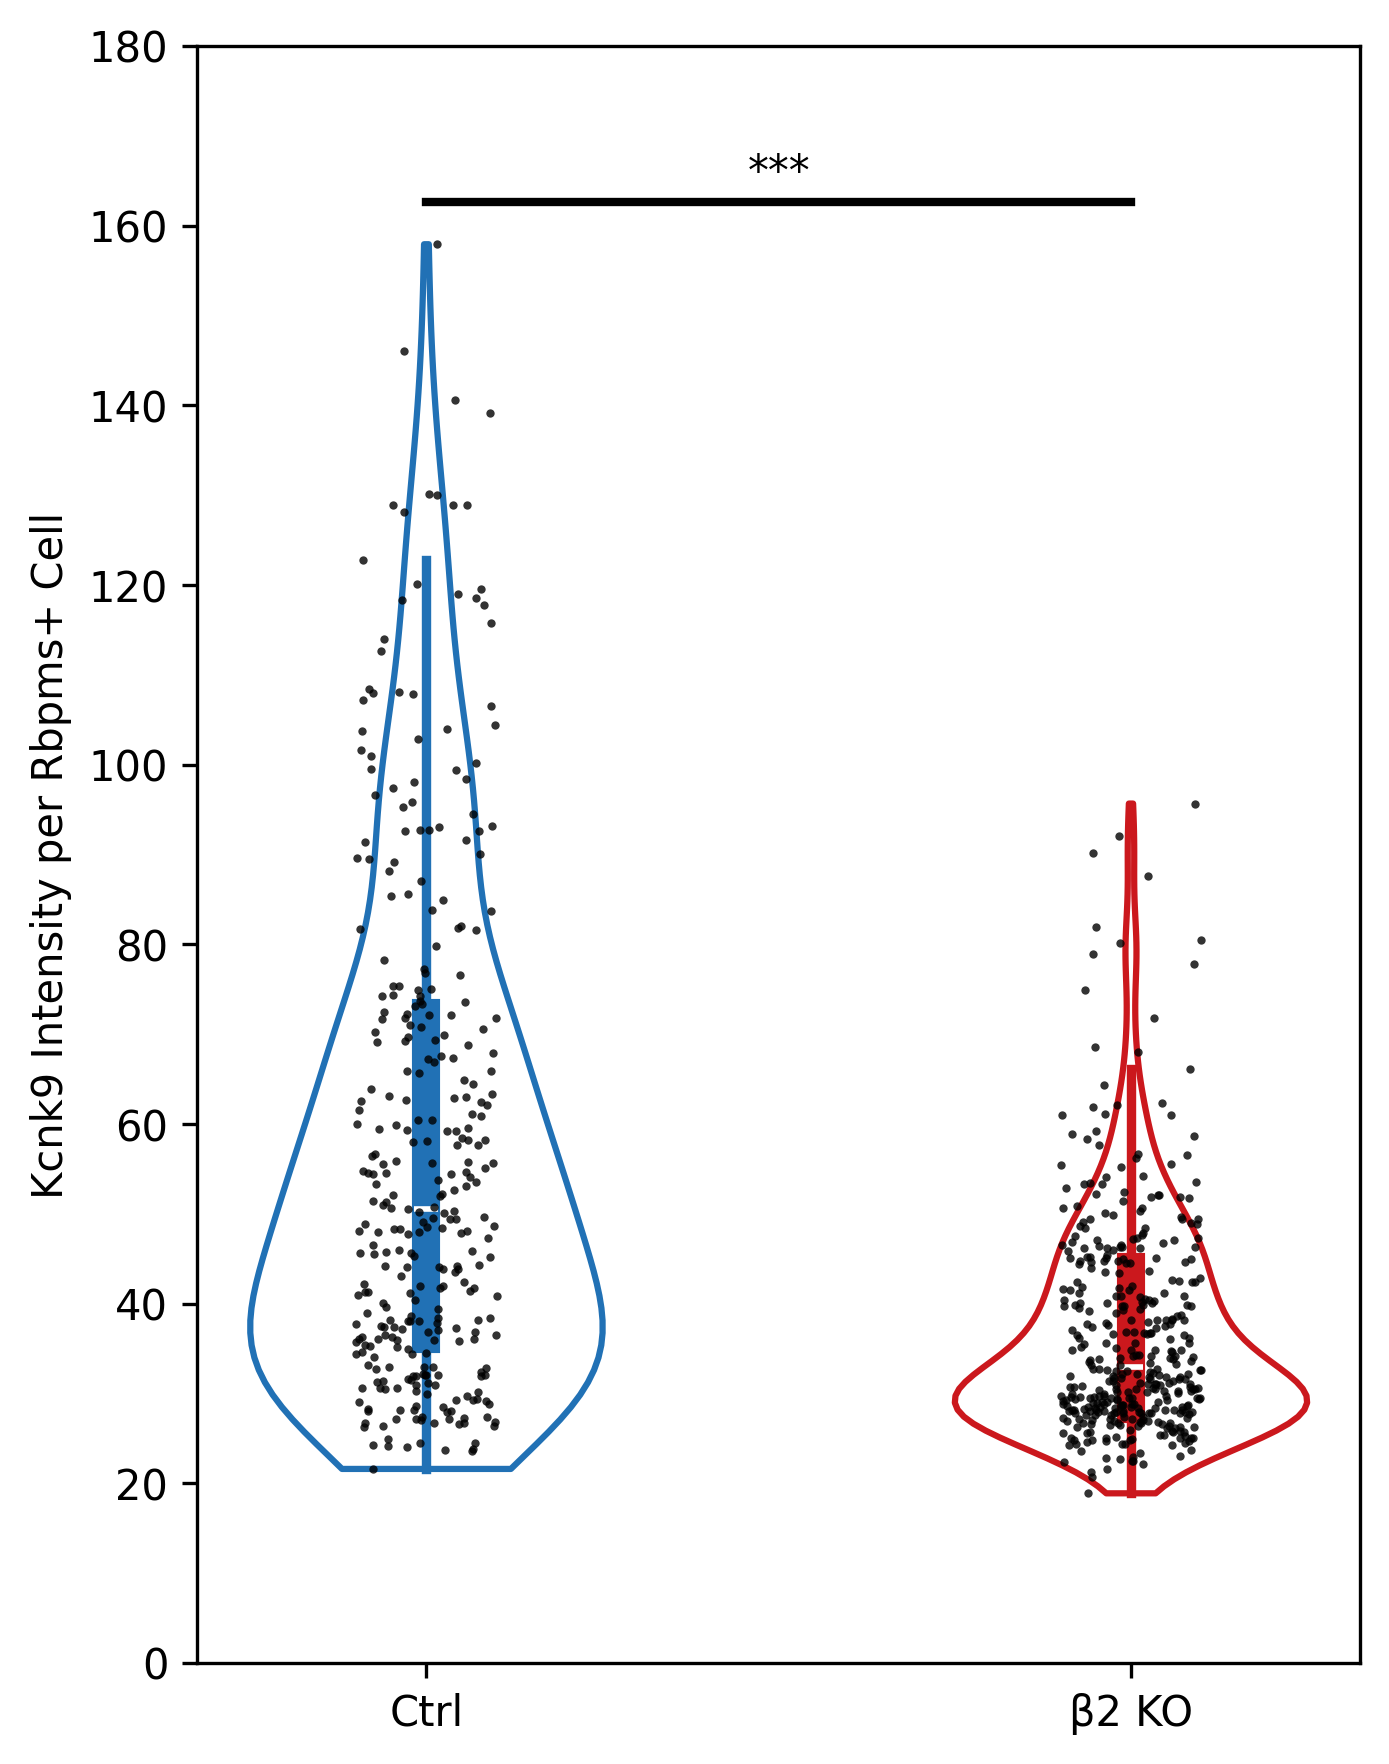

In [45]:
fig, axs = plt.subplots(figsize=(5,7))
sns.violinplot(int_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)
sns.stripplot(int_dist_plot_agg, color='black', alpha=0.8, size=2)
pval_line_height = 1.03*np.max(int_dist_plot_agg[0])
plt.plot([0,1],[pval_line_height, pval_line_height], c='black', lw=2)
plt.xticks([0,1], ["Ctrl", "β2 KO"])
plt.ylabel("Kcnk9 Intensity per Rbpms+ Cell")
plt.text(0.5, 1.02*pval_line_height, f'***', ha='center', va='center')
plt.ylim([0,180])
plt.savefig('FISH_Quant_Int_Rbpms.png', dpi=500)

In [46]:
smi32_count_test = stats.mannwhitneyu(smi32_positive_count_dist_plot_agg[0], smi32_positive_count_dist_plot_agg[1], alternative='two-sided')

C:\Users\pomat\AppData\Local\Temp\ipykernel_26004\1246027343.py:2: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(smi32_positive_count_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)


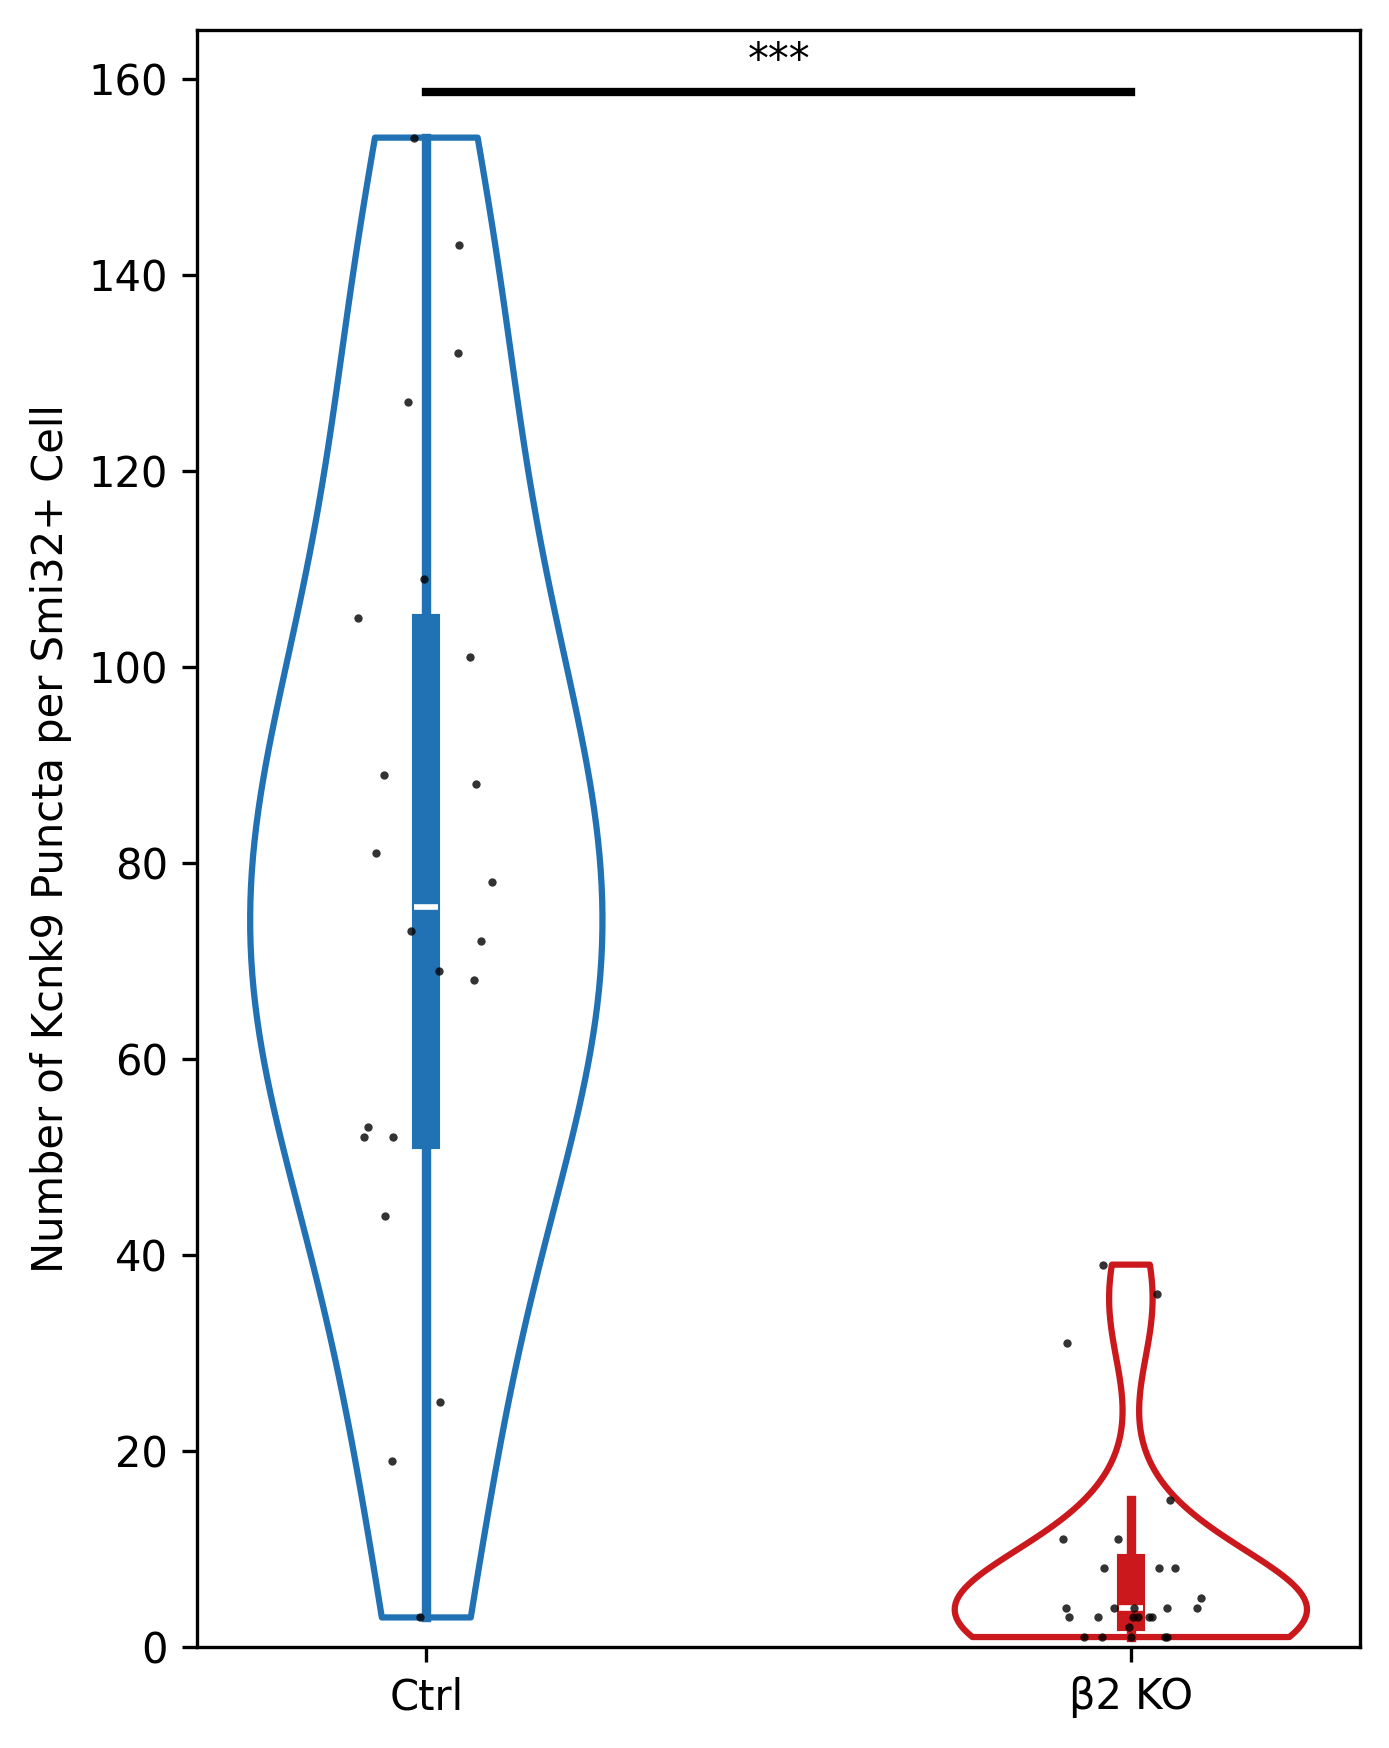

In [49]:
fig, axs = plt.subplots(figsize=(5,7))
sns.violinplot(smi32_positive_count_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)
sns.stripplot(smi32_positive_count_dist_plot_agg, color='black', alpha=0.8, size=2)
pval_line_height = 1.03*np.max(smi32_positive_count_dist_plot_agg[0])
plt.plot([0,1],[pval_line_height, pval_line_height], c='black', lw=2)
plt.xticks([0,1], ["Ctrl", "β2 KO"])
plt.ylabel("Number of Kcnk9 Puncta per Smi32+ Cell")
plt.text(0.5, 1.02*pval_line_height, f'***', ha='center', va='center')
plt.ylim([0,165])
plt.savefig('FISH_Quant_Count_Smi32.svg', dpi=500)

In [51]:
smi32_int_test = stats.mannwhitneyu(smi32_positive_int_dist_plot_agg[0], smi32_positive_int_dist_plot_agg[1], alternative='two-sided')

C:\Users\pomat\AppData\Local\Temp\ipykernel_26004\65334247.py:2: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(smi32_positive_int_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)


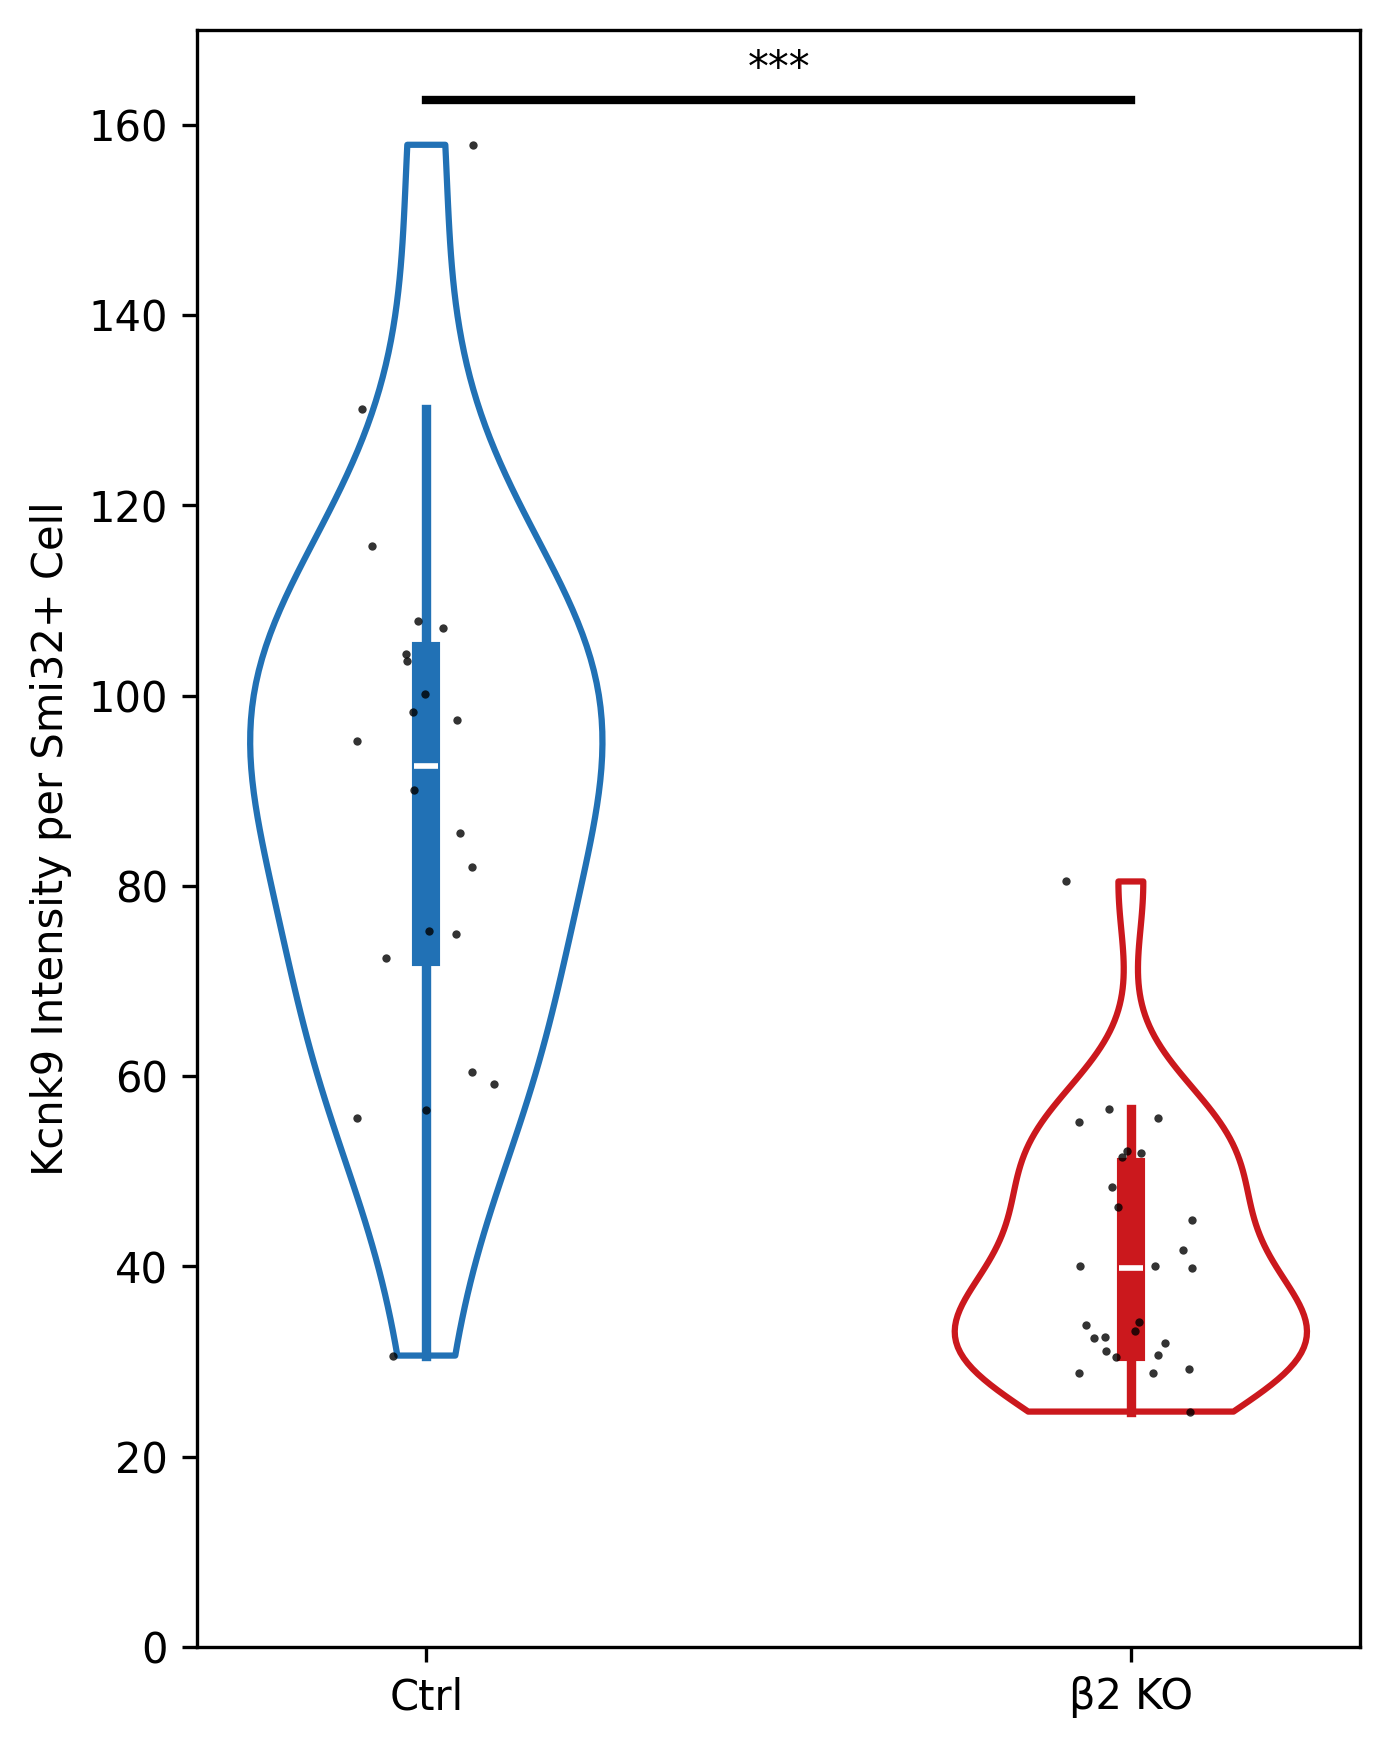

In [55]:
fig, axs = plt.subplots(figsize=(5,7))
sns.violinplot(smi32_positive_int_dist_plot_agg, width=0.5, fill=False, palette=sns.color_palette(palette, 14), cut=0)
sns.stripplot(smi32_positive_int_dist_plot_agg, color='black', alpha=0.8, size=2)
pval_line_height = 1.03*np.max(smi32_positive_int_dist_plot_agg[0])
plt.plot([0,1],[pval_line_height, pval_line_height], c='black', lw=2)
plt.xticks([0,1], ["Ctrl", "β2 KO"])
plt.ylabel("Kcnk9 Intensity per Smi32+ Cell")
plt.text(0.5, 1.02*pval_line_height, f'***', ha='center', va='center')
plt.ylim([0,170])
plt.savefig('FISH_Quant_Int_Smi32.svg', dpi=500)